
Loading TRAIN isotherms...
Loading TEST isotherms...

Aligning feature sets...
Common candidate features: 34

Train isotherms: [3.8, 4.1, 4.2, 4.4]
Test  isotherms: [4.5]
Train samples: 19244 | Test samples: 8824

Computing MI + mRMR on TRAIN only...
mRMR step 01: density_ratio_sigma (score=2.2954, relevance=2.2954)
mRMR step 02: abs_flame_prop_vel_normal (score=0.3685, relevance=1.3045)
mRMR step 03: curvature (score=0.2505, relevance=1.2065)
mRMR step 04: H2O (score=0.3531, relevance=2.2226)
mRMR step 05: flow_velocity_tangential (score=0.2166, relevance=1.6991)
mRMR step 06: total_heat_conduction (score=0.0478, relevance=1.5786)
mRMR step 07: strain_rate (score=0.0643, relevance=0.8695)
mRMR step 08: stretch_rate (score=0.1331, relevance=1.1980)
mRMR step 09: gradT (score=0.1460, relevance=1.7393)
mRMR step 10: u (score=0.0901, relevance=1.4762)

Selected features (mRMR order):
  01. density_ratio_sigma
  02. abs_flame_prop_vel_normal
  03. curvature
  04. H2O
  05. flow_velocity_t

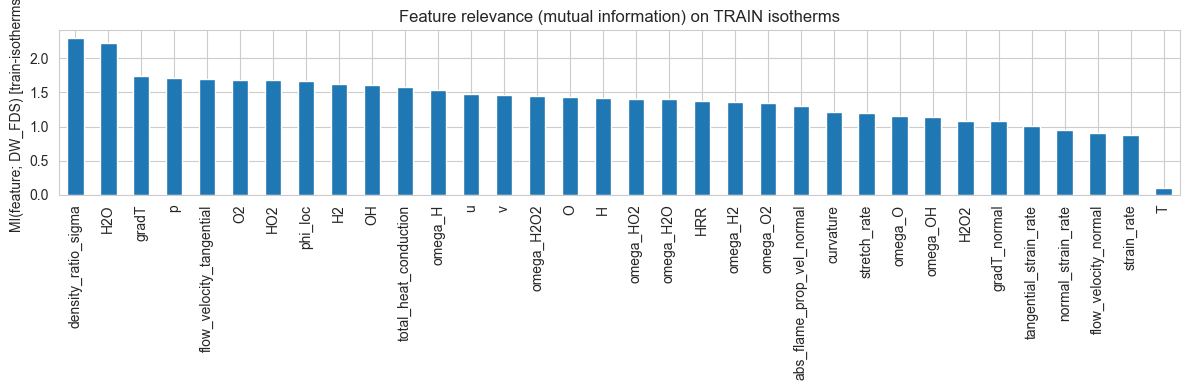


Computing convergence curve (TRAIN isotherms only)...


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


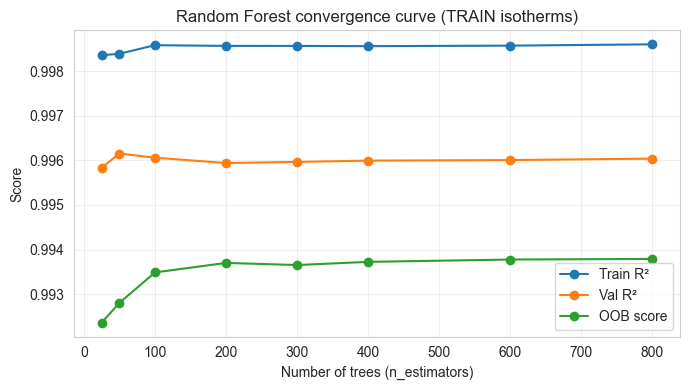


Convergence history:
   n_estimators  r2_train    r2_val  oob_score
0            25  0.998357  0.995834   0.992361
1            50  0.998389  0.996151   0.992804
2           100  0.998581  0.996060   0.993487
3           200  0.998565  0.995939   0.993700
4           300  0.998565  0.995965   0.993652
5           400  0.998559  0.995993   0.993723
6           600  0.998571  0.996006   0.993776
7           800  0.998601  0.996038   0.993790

=== RF (mRMR top-10) | Train isos [3.8, 4.1, 4.2, 4.4] -> Test isos [4.5] | Train t=212,L=100 -> Test t=212,L=100 ===
R^2  : 0.6751
RMSE : 3.231956e-01
MAE  : 2.772197e-01


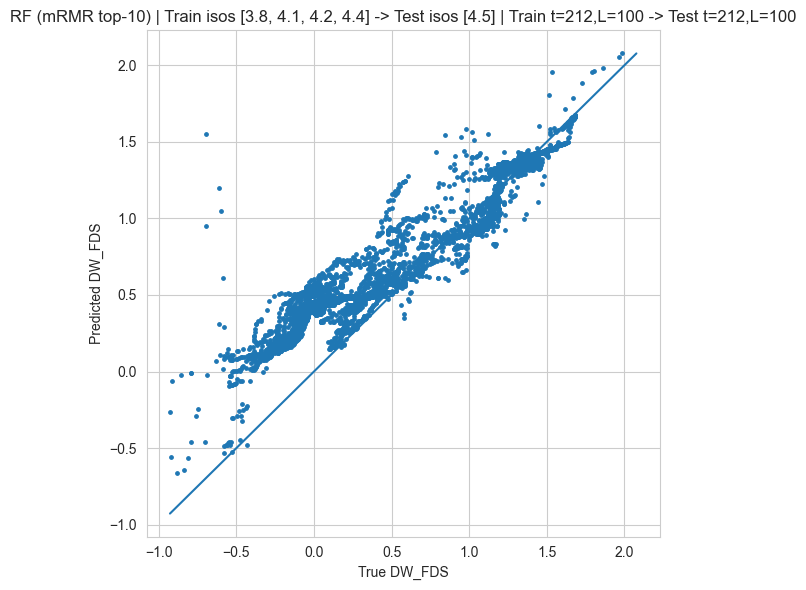

In [4]:
# ============================================================
# Train on a subset of isotherms and predict a DIFFERENT isotherm,
# with MI+mRMR feature selection (TRAIN only) and an RF convergence curve.
# Curvature-only baseline REMOVED as requested.
# ============================================================

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedShuffleSplit


# ============================================================
# USER SETTINGS
# ============================================================

BASE_DIR = Path("../data/isocontours")

TARGET_VAR = "DW_FDS"

# Train on these isotherms:
TRAIN_ISOLEVELS = [3.8, 4.1, 4.2, 4.4]
# Test on a different isotherm (or several):
TEST_ISOLEVELS  = [4.5]

# Exclude non-features
COLS_TO_EXCLUDE = [
    "x", "y", "z",
    TARGET_VAR,
    "N2", "omega_N2",
]

# Include c_iso as a feature (recommended when training across isotherms)
INCLUDE_C_ISO_AS_FEATURE = False

# mRMR: number of selected features
K_SELECT = 10

# RF hyperparameters (n_estimators will be overwritten for convergence curve)
RF_PARAMS = dict(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=0,
    n_jobs=-1,
)

# Convergence curve: forest sizes to probe
N_ESTIMATORS_GRID = [25, 50, 100, 200, 300, 400, 600, 800]


# ------------------------------------------------------------
# Define cases (can be same or different)
# ------------------------------------------------------------

@dataclass(frozen=True)
class CaseConfig:
    phi: float = 0.40
    lat_size: str = "100"
    time_step: int = 212
    post: bool = True
    multiple_runs: bool = False
    n_RUN: int = 1
    Soret_term: bool = False
    Soret_positive: bool = False
    h_tag: str = "h400"


# Same-case example (predict different isotherm at same timestep/domain):
TRAIN_CASE = CaseConfig(phi=0.40, lat_size="100", time_step=212, post=True)
TEST_CASE  = CaseConfig(phi=0.40, lat_size="100", time_step=212, post=True)

# If you want cross-case AND cross-isotherm, change TEST_CASE lat_size/time_step.


# ============================================================
# IO helpers
# ============================================================

def case_folder(cfg: CaseConfig) -> Path:
    phi_dir = BASE_DIR / f"phi{cfg.phi:.2f}"

    if cfg.Soret_term and cfg.Soret_positive:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref_Soret_positive"
    elif cfg.Soret_term:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"
    else:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"

    if cfg.multiple_runs:
        folder = folder / f"RUN0{cfg.n_RUN}"

    return folder


def isofile_name(cfg: CaseConfig, c_val: float) -> str:
    if cfg.post:
        return f"extracted_flame_front_post_{cfg.time_step}_iso_{c_val}.csv"
    return f"extracted_flame_front_{cfg.time_step}_iso_{c_val}.csv"


def load_isocontours(cfg: CaseConfig, isolevels: List[float]) -> Dict[float, pd.DataFrame]:
    folder = case_folder(cfg)
    dataset: Dict[float, pd.DataFrame] = {}

    for c_val in isolevels:
        fpath = folder / isofile_name(cfg, c_val)
        if not fpath.exists():
            raise FileNotFoundError(
                f"Missing file:\n  {fpath}\n"
                f"Check BASE_DIR / phi / folder naming / time_step / lat_size / post flag."
            )
        df = pd.read_csv(fpath).copy()
        df["c_iso"] = float(c_val)
        dataset[c_val] = df

    return dataset


def concat_fronts(dataset: Dict[float, pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(list(dataset.values()), ignore_index=True)


# ============================================================
# Feature preparation
# ============================================================

def build_feature_list(df: pd.DataFrame, target_var: str) -> List[str]:
    cols_excl = set(COLS_TO_EXCLUDE)
    if not INCLUDE_C_ISO_AS_FEATURE:
        cols_excl.add("c_iso")

    feature_cols = [c for c in df.columns if c not in cols_excl]
    numeric_features = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]

    if target_var not in df.columns:
        raise ValueError(f"Target column '{target_var}' not found.")

    return numeric_features


def align_train_test_features(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    target_var: str,
) -> List[str]:
    train_feats = set(build_feature_list(df_train, target_var))
    test_feats  = set(build_feature_list(df_test,  target_var))
    common = sorted(list(train_feats.intersection(test_feats)))
    if len(common) == 0:
        raise ValueError("No common numeric feature columns between train/test.")
    return common


def clean_xy(df: pd.DataFrame, feature_cols: List[str], target_var: str):
    df_clean = df.dropna(subset=feature_cols + [target_var]).copy()
    X = df_clean[feature_cols].to_numpy()
    y = df_clean[target_var].to_numpy()
    return X, y, df_clean


# ============================================================
# MI + greedy mRMR (train only)
# ============================================================

def mrmr_greedy(
    X: np.ndarray,
    y: np.ndarray,
    feature_cols: List[str],
    k_select: int,
    random_state: int = 0
):
    n_samples, n_features = X.shape
    k_select = int(min(k_select, n_features))

    mi_ft = mutual_info_regression(X, y, random_state=random_state)
    mi_rank = pd.Series(mi_ft, index=feature_cols).sort_values(ascending=False)

    mi_ff = np.zeros((n_features, n_features), dtype=float)
    for i in range(n_features):
        Xi = X[:, [i]]
        for j in range(i + 1, n_features):
            Xj = X[:, j]
            mi_ij = mutual_info_regression(Xi, Xj, random_state=random_state)[0]
            mi_ff[i, j] = mi_ij
            mi_ff[j, i] = mi_ij

    selected_idx = []
    selected_feats = []

    for step in range(k_select):
        best_score = -np.inf
        best_j = None

        for j in range(n_features):
            if j in selected_idx:
                continue
            relevance = mi_ft[j]
            redundancy = 0.0 if len(selected_idx) == 0 else float(np.mean([mi_ff[j, s] for s in selected_idx]))
            score = relevance - redundancy
            if score > best_score:
                best_score = score
                best_j = j

        assert best_j is not None
        selected_idx.append(best_j)
        selected_feats.append(feature_cols[best_j])
        print(f"mRMR step {step+1:02d}: {feature_cols[best_j]} "
              f"(score={best_score:.4f}, relevance={mi_ft[best_j]:.4f})")

    return selected_feats, mi_rank


# ============================================================
# RF convergence curve (train only)
# ============================================================

def rf_convergence_curve(
    X: np.ndarray,
    y: np.ndarray,
    strata: np.ndarray,
    rf_base_params: dict,
    n_estimators_grid: List[int],
    val_fraction: float = 0.2,
    random_state: int = 0,
    use_oob: bool = True,
) -> pd.DataFrame:
    """
    Convergence curve for RandomForest by increasing n_estimators with warm_start.
    Uses a stratified train/val split based on strata (e.g. c_iso).
    """
    if len(np.unique(strata)) < 2:
        raise ValueError("Strata must have at least 2 classes for stratified split (e.g. multiple train isotherms).")

    sss = StratifiedShuffleSplit(
        n_splits=1, test_size=val_fraction, random_state=random_state
    )
    tr_idx, va_idx = next(sss.split(X, strata))

    Xtr, ytr = X[tr_idx], y[tr_idx]
    Xva, yva = X[va_idx], y[va_idx]

    params = dict(rf_base_params)
    if use_oob:
        params["bootstrap"] = True
        params["oob_score"] = True

    rf = RandomForestRegressor(
        n_estimators=1,
        warm_start=True,
        **params,
    )

    rows = []
    for n_est in n_estimators_grid:
        rf.set_params(n_estimators=int(n_est))
        rf.fit(Xtr, ytr)

        r2_tr = rf.score(Xtr, ytr)
        r2_va = rf.score(Xva, yva)

        row = {"n_estimators": int(n_est), "r2_train": float(r2_tr), "r2_val": float(r2_va)}
        if use_oob:
            row["oob_score"] = float(rf.oob_score_)
        rows.append(row)

    hist = pd.DataFrame(rows)

    plt.figure(figsize=(7, 4))
    plt.plot(hist["n_estimators"], hist["r2_train"], marker="o", label="Train R²")
    plt.plot(hist["n_estimators"], hist["r2_val"], marker="o", label="Val R²")
    if use_oob and "oob_score" in hist.columns:
        plt.plot(hist["n_estimators"], hist["oob_score"], marker="o", label="OOB score")
    plt.xlabel("Number of trees (n_estimators)")
    plt.ylabel("Score")
    plt.title("Random Forest convergence curve (TRAIN isotherms)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return hist


# ============================================================
# Training / Evaluation (final test isotherm)
# ============================================================

def fit_and_evaluate(Xtr, ytr, Xte, yte, model, label: str):
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)

    r2 = r2_score(yte, ypred)
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    mae  = float(mean_absolute_error(yte, ypred))

    print(f"\n=== {label} ===")
    print(f"R^2  : {r2:.4f}")
    print(f"RMSE : {rmse:.6e}")
    print(f"MAE  : {mae:.6e}")

    plt.figure(figsize=(6, 6))
    plt.scatter(yte, ypred, s=6)
    lo = min(np.min(yte), np.min(ypred))
    hi = max(np.max(yte), np.max(ypred))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel(f"True {TARGET_VAR}")
    plt.ylabel(f"Predicted {TARGET_VAR}")
    plt.title(label)
    plt.tight_layout()
    plt.show()

    return {"r2": float(r2), "rmse": rmse, "mae": mae}


# ============================================================
# Main
# ============================================================

def main():
    if set(TRAIN_ISOLEVELS).intersection(TEST_ISOLEVELS):
        raise ValueError("TRAIN_ISOLEVELS and TEST_ISOLEVELS overlap. Make them disjoint.")

    print("\nLoading TRAIN isotherms...")
    train_dataset = load_isocontours(TRAIN_CASE, TRAIN_ISOLEVELS)
    df_train = concat_fronts(train_dataset)

    print("Loading TEST isotherms...")
    test_dataset = load_isocontours(TEST_CASE, TEST_ISOLEVELS)
    df_test = concat_fronts(test_dataset)

    print("\nAligning feature sets...")
    common_features = align_train_test_features(df_train, df_test, TARGET_VAR)
    print(f"Common candidate features: {len(common_features)}")

    X_train, y_train, df_train_clean = clean_xy(df_train, common_features, TARGET_VAR)
    X_test,  y_test,  df_test_clean  = clean_xy(df_test,  common_features, TARGET_VAR)

    print(f"\nTrain isotherms: {TRAIN_ISOLEVELS}")
    print(f"Test  isotherms: {TEST_ISOLEVELS}")
    print(f"Train samples: {len(y_train)} | Test samples: {len(y_test)}")

    # -------------------------
    # Feature selection on TRAIN
    # -------------------------
    print("\nComputing MI + mRMR on TRAIN only...")
    selected_features, mi_rank = mrmr_greedy(
        X_train, y_train,
        common_features,
        k_select=K_SELECT,
        random_state=0
    )

    print("\nSelected features (mRMR order):")
    for i, f in enumerate(selected_features, 1):
        print(f"  {i:02d}. {f}")

    plt.figure(figsize=(12, 4))
    mi_rank.plot(kind="bar")
    plt.ylabel(f"MI(feature; {TARGET_VAR}) [train-isotherms]")
    plt.title("Feature relevance (mutual information) on TRAIN isotherms")
    plt.tight_layout()
    plt.show()

    # Build matrices for selected features
    feat_to_idx = {f: i for i, f in enumerate(common_features)}
    sel_idx = [feat_to_idx[f] for f in selected_features]

    X_train_sel = X_train[:, sel_idx]
    X_test_sel  = X_test[:,  sel_idx]

    # -------------------------
    # Convergence curve (TRAIN only)
    # -------------------------
    strata = df_train_clean["c_iso"].to_numpy()
    print("\nComputing convergence curve (TRAIN isotherms only)...")
    hist = rf_convergence_curve(
        X=X_train_sel,
        y=y_train,
        strata=strata,
        rf_base_params={k: v for k, v in RF_PARAMS.items() if k != "n_estimators"},
        n_estimators_grid=N_ESTIMATORS_GRID,
        val_fraction=0.2,
        random_state=0,
        use_oob=True,
    )
    print("\nConvergence history:")
    print(hist)

    # -------------------------
    # Final training (full TRAIN) and evaluation on TEST isotherm
    # -------------------------
    rf_final = RandomForestRegressor(**RF_PARAMS)
    fit_and_evaluate(
        X_train_sel, y_train,
        X_test_sel,  y_test,
        rf_final,
        label=(
            f"RF (mRMR top-{len(selected_features)}) | Train isos {TRAIN_ISOLEVELS} -> Test isos {TEST_ISOLEVELS} "
            f"| Train t={TRAIN_CASE.time_step},L={TRAIN_CASE.lat_size} -> Test t={TEST_CASE.time_step},L={TEST_CASE.lat_size}"
        )
    )


if __name__ == "__main__":
    main()
